<a href="https://colab.research.google.com/github/Sarik123-long/CodeAlpha_ProjectName/blob/main/Implement_a_U_Net_model_to_perform_lung_segmentation_on_CT_scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/finding-lungs-in-ct-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/finding-lungs-in-ct-data


Found 267 image files and 267 mask files.

Preprocessing complete.
Shape of X_train: (213, 128, 128, 1)
Shape of y_train: (213, 128, 128, 1)
Shape of X_val: (54, 128, 128, 1)
Shape of y_val: (54, 128, 128, 1)

U-Net model instantiated.
Model compiled successfully.
Starting model training for 1 epochs with batch size 32...
7/7 ━━━━━━━━━━━━━━━━━━━━ 551s 77s/step - accuracy: 0.7115 - loss: 0.6484 - mean_io_u: 0.3815 - val_accuracy: 0.7633 - val_loss: 0.5828 - val_mean_io_u: 0.3816
Model training finished.

Evaluating the model on the validation set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 31s 13s/step - accuracy: 0.7654 - loss: 0.5820 - mean_io_u: 0.3827
Validation Loss: 0.582760214805603
Validation Accuracy: 0.7632638216018677
Validation Mean IoU: 0.38163191080093384

Visualizing predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


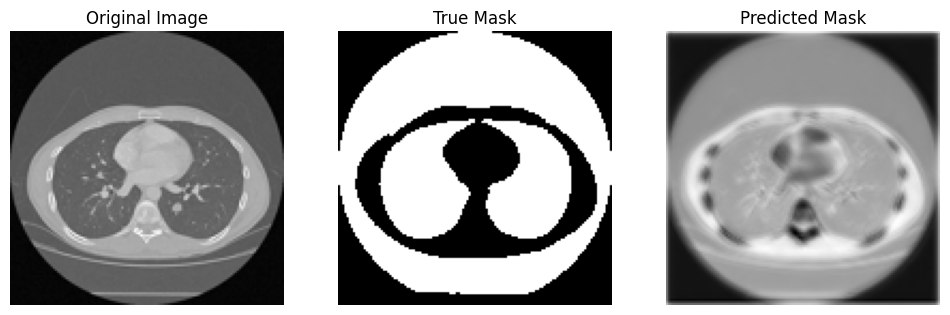

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step


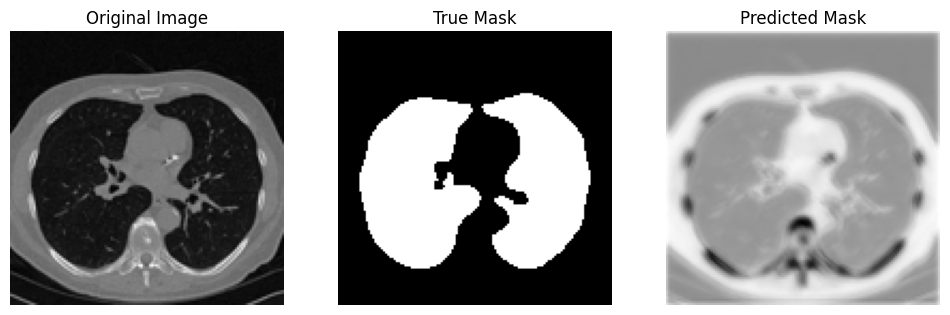

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step


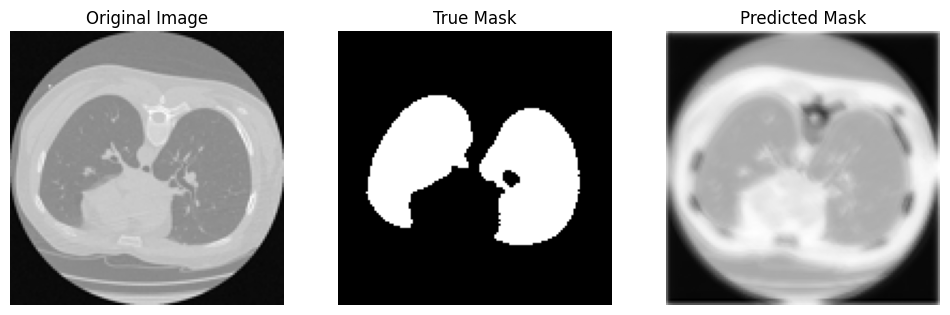

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step


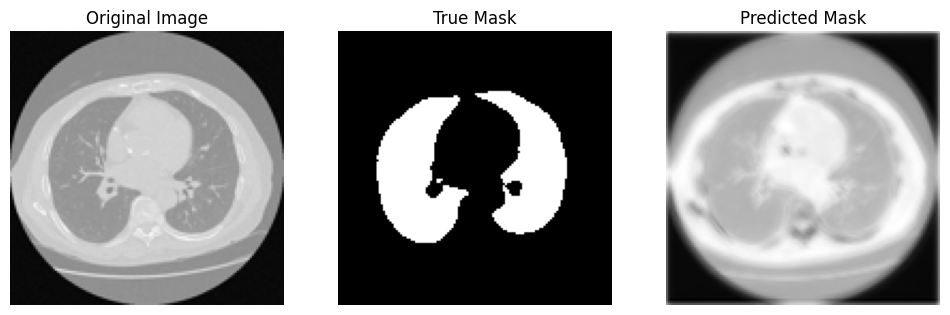

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step


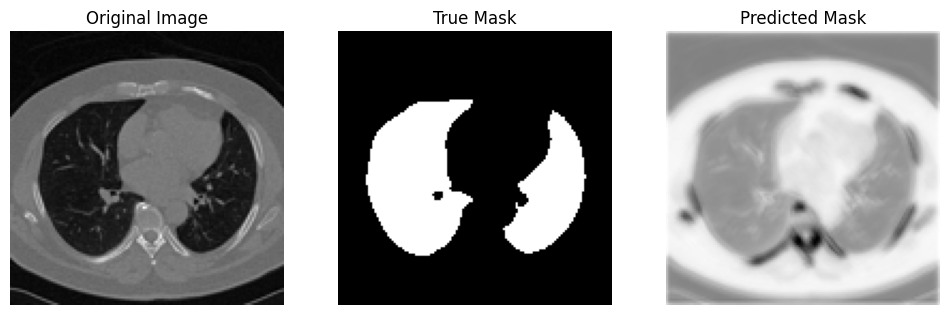

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image # Import Pillow
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

# --- Data Loading and Preprocessing ---

# Define the path where the dataset was downloaded
data_path = "/root/.cache/kagglehub/datasets/kmader/finding-lungs-in-ct-data/versions/2"
image_dir = os.path.join(data_path, "2d_images")
mask_dir = os.path.join(data_path, "2d_masks")

# Get sorted list of image and mask files
image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.tif')])

print(f"Found {len(image_files)} image files and {len(mask_files)} mask files.")

# Define image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Function to load and preprocess images and masks
def load_and_preprocess_image(image_path, mask_path):
    image = Image.open(image_path)
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image = np.array(image).astype(np.float32)
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize to [0, 1]

    mask = Image.open(mask_path)
    mask = mask.resize((IMG_WIDTH, IMG_HEIGHT))
    mask = np.array(mask).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    mask = np.round(mask / 255.0)  # Normalize and binarize mask

    return image, mask

# Create dataset arrays
images, masks = [], []
for img_path, mask_path in zip(image_files, mask_files):
    img, msk = load_and_preprocess_image(img_path, mask_path)
    images.append(img)
    masks.append(msk)

images = np.array(images)
masks = np.array(masks)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print("\nPreprocessing complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")

# --- U-Net Model Definition ---
def unet_model(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    return Model(inputs, outputs)

# Instantiate and compile the model
input_shape = X_train.shape[1:]
model = unet_model(input_shape=input_shape)
print("\nU-Net model instantiated.")

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=2)])
print("Model compiled successfully.")

# Train the model (EPOCHS = 3)
epochs = 1
batch_size = 32

print(f"Starting model training for {epochs} epochs with batch size {batch_size}...")
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val))
print("Model training finished.")

# --- Evaluation ---
print("\nEvaluating the model on the validation set...")
loss, accuracy, mean_iou = model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Mean IoU: {mean_iou}")

# --- Visualization ---
print("\nVisualizing predictions...")
num_examples = 5
example_indices = np.random.choice(len(X_val), num_examples, replace=False) # Corrected variable name

for i in example_indices:
    # Get the original image, true mask, and predicted mask
    original_image = X_val[i]
    true_mask = y_val[i]
    predicted_mask = model.predict(np.expand_dims(original_image, axis=0))[0]

    # Plot the images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image[:, :, 0], cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask[:, :, 0], cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_mask[:, :, 0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()